# Regularized Regression

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available
# on an “as is,” “as available,” and “with all faults” basis, solely for
# illustrative purposes, and without warranty or representation of any kind.
# This solution is experimental, unsupported and provided solely for your
# convenience. Your use of it is subject to your agreements with Google, as
# applicable, and may constitute a beta feature as defined under those
# agreements.  To the extent that you make any data available to Google in
# connection with your use of the solution, you represent and warrant that you
# have all necessary and appropriate rights, consents and permissions to permit
# Google to use and process that data.  By using any portion of this solution,
# you acknowledge, assume and accept all risks, known and unknown, associated
# with its usage, including with respect to your deployment of any portion of
# this solution in your systems, or usage in connection with your business,
# if at all.
###########################################################################

## 0) Dependencies

In [1]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'OnStar_RBA_0708' #add proj name and dataset

In [2]:
# Calculating Relative Importance
!pip install relativeImp
!pip install shap

In [3]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

# data processing libraries
import numpy as np
from numpy.core.numeric import NaN
import pandas as pd
import pandas_gbq
import datetime

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, LeavePOut
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import TimeSeriesSplit

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Calculating Relative Importance
from relativeImp import relativeImp
import shap

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics


from google.colab import files


magics.context.project = project_name  #update your project name

client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False

## 1) Import dataset

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
# %%bigquery df
# SELECT *
# FROM `.RBA_demo.cleaned_data`
# ORDER BY date; #update with project name.

In [4]:
#update file name
file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data_0708.csv'
df_raw = pd.read_csv(file_name)
df_raw.fillna(0, inplace=True)

df=df_raw.copy()
#df=df_raw.drop(columns=['DIV_WYG_PPl21_0p0_0d0_12'],axis=1).copy()
df.head()


,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_0,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0,C_DIV_BUY_PREMIUMl21_0p0_0d0_06,C_DIV_BUY_SSl21_0p0_0d0_12,C_DIV_CONN_DATAl21_0p0_0d0_12,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_0,...,DIV_PLANPAGE_ESSl21_0p0_0d0_06,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_12,Is_Holiday,Is_NYE
0,10/13/2023,729,-1.205102,-0.307094,-1.194541,-0.474351,-0.705212,-0.093944,-0.554724,0.785728,...,-0.380979,-0.773997,-0.693878,-1.450006,-0.612203,-1.013031,0.706098,-0.435712,0,0
1,10/14/2023,936,-1.108022,-1.827942,-0.955605,-0.772672,0.808002,-0.579551,-0.109231,0.111436,...,-0.395107,-0.783669,-0.566780,-1.284105,-0.663551,-1.013031,0.622132,0.506578,0,0
2,10/15/2023,787,-1.593424,-2.045206,-1.855596,-1.496538,-1.079448,-1.391312,0.510846,-1.068574,...,-0.467866,-1.784458,-0.687852,-1.478292,-1.195888,-1.013031,0.586147,-1.075122,0,0
3,10/16/2023,1030,-1.156562,-1.502046,-0.999979,-0.698092,-0.916737,-0.572303,-1.560092,-0.731428,...,-0.396858,-0.842286,0.757340,-0.777197,-0.168277,0.603343,0.686106,-1.277042,0,0
4,10/17/2023,950,-1.302183,-1.393414,-1.002255,-1.470215,-0.664534,-0.825978,-1.385507,-0.267853,...,0.157420,-0.450040,0.104867,-1.071958,-0.427817,-0.819067,0.098345,-1.277042,0,0


In [ ]:
#df.head()

### 1.1) Define KPI column and feature set

In [5]:
date_col = 'Date' #@param {type:"string"}
df = df.drop(columns = [date_col]) # drop date column since it's not part of the feature set

KPI_COL = "A_OC_GOOGLE_SHOPPING" #@param {type:"string"}
y = df[KPI_COL]
X = df[df.columns[df.columns != KPI_COL]].values

## 2) Build RBA Model

Create a linear model to measure the impact of digital media (x variables) on conversions (y variable).

Different regularization techniques, such as Ridge or Lasso, can be implemented to adjust for highly correlated features.

### 2.1) Run the model and print evaluation metrics

In [6]:
train_test_split = 'N'
test_size = 0.1 #@param {type:"number"}

#### 2.1A) Ridge Regression:

In [13]:
if train_test_split == 'Y':

  # separate data into train and test based on fraction of test size
  train_df = df[:round(len(df.index)*(1-test_size))]
  test_df = df[round(len(df.index)*(1-test_size)):]

  # split train and test into x/y columns
  train_x = train_df[train_df.columns[train_df.columns != KPI_COL]].values
  test_x = test_df[test_df.columns[test_df.columns != KPI_COL]].values

  train_y = train_df[KPI_COL]
  test_y = test_df[KPI_COL]

  # run the model on the training data
  reg = Ridge().fit(train_x,train_y)

  # eval metrics - r-squared on training data
  print('Training Rsquared: ' , round(reg.score(train_x,train_y),2))
  print('Test Rsquared: ' , round(reg.score(test_x,test_y),2))

  # Generate predictions to calculate MAE, MSE, RMSE
  Y_prediction = reg.predict(test_x)
  print('MAE: ' , round(mean_absolute_error(test_y,Y_prediction),2))
  print('MSE: ', round(mean_squared_error(test_y,Y_prediction),2))
  print('RMSE: ',round(np.sqrt(mean_squared_error(test_y,Y_prediction)),2))

else:
  # run the model on the full dataset
  reg = Ridge().fit(X,y)

  # Generate predictions to calculate residuals
  Y_prediction = reg.predict(X)

  # eval metrics - r-squared on full dataset
  print('R-squared: ',round(reg.score(X,y),2))

R-squared:  0.94


In [47]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import numpy as np

# Fit the Ridge model
#ridge_reg = Ridge(alpha=1.0)  # You can adjust the alpha value as needed
ridge_reg = Ridge(alpha=10.0)  # Based on CV optimization
ridge_reg.fit(X, y)
reg_optimal_alpha_ridge = ridge_reg.fit(X, y)

# Predict and calculate R-squared
y_pred = ridge_reg.predict(X)
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')

# Assuming 'train_x' is a DataFrame or you have access to the original DataFrame's column names

dt_X = df[df.columns[df.columns != KPI_COL]]
feature_names = dt_X.columns  # Replace with  DataFrame's columns if 'train_x' is not a DataFrame

# Getting the coefficients from the Ridge model
coefficients = ridge_reg.coef_

# Pairing each feature name with its corresponding coefficient
for feature, coeff in zip(feature_names, coefficients):
    print(f'{feature}: {coeff}')

# Also printing the intercept
print('Intercept:', ridge_reg.intercept_)




R-squared: 0.931540975338163
Mean Squared Error: 19998.836731175743
C_DIV_BUY_CONNECTEDl21_0p0_0d0_0: 0.0
C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0: -12.462645018852125
C_DIV_BUY_PREMIUMl21_0p0_0d0_06: -7.161246361934434
C_DIV_BUY_SSl21_0p0_0d0_12: 42.6153480658923
C_DIV_CONN_DATAl21_0p0_0d0_12: -28.303705508105192
C_DIV_CONN_REMOTEl21_0p0_0d0_12: 9.957149265831076
C_DIV_CONN_TRYl21_0p0_0d0_06: 19.919386321114615
C_DIV_GETNOW_CONNl21_0p0_0d0_0: 10.59281109417438
C_DIV_GETNOW_ESSl21_0p0_0d0_12: 23.57012651079631
C_DIV_GETNOW_PREMl21_0p0_0d0_06: -5.092085645703634
C_DIV_GETNOW_SSl21_0p0_0d0_12: 26.552823927240233
C_PP_PKG_APP_ACCESSl21_0p0_0d0_12: -4.796601923771671
C_PP_PKG_CONNECTEDl21_0p0_0d0_12: -0.9167497369136299
C_PP_PKG_ESSl21_0p0_0d0_06: -2.4435396352372
C_PP_PKG_PREMl21_0p0_0d0_0: 0.7298506399773899
C_PP_PKG_REMOTEl21_0p0_0d0_0: 0.06719814101401812
C_PP_PKG_SCl21_0p0_0d0_06: 75.51591921692703
C_PP_PKG_SSl21_0p0_0d0_06: -3.9864011916656468
DIV_GMOC_SHOP_ESSl21_0p0_0d0_0: -10.63919664243

#### 2.1B) Lasso Regression:

In [32]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

if train_test_split == 'Y':

    # separate data into train and test based on fraction of test size
    train_df = df[:round(len(df.index)*(1-test_size))]
    test_df = df[round(len(df.index)*(1-test_size)):]

    # split train and test into x/y columns
    train_x = train_df[train_df.columns[train_df.columns != KPI_COL]].values
    test_x = test_df[test_df.columns[test_df.columns != KPI_COL]].values

    train_y = train_df[KPI_COL]
    test_y = test_df[KPI_COL]

    # run the model on the training data
    reg = Lasso().fit(train_x, train_y)

    # eval metrics - r-squared on training data
    print('Training Rsquared: ', round(reg.score(train_x, train_y), 2))
    print('Test Rsquared: ', round(reg.score(test_x, test_y), 2))

    # Generate predictions to calculate MAE, MSE, RMSE
    Y_prediction = reg.predict(test_x)
    print('MAE: ', round(mean_absolute_error(test_y, Y_prediction), 2))
    print('MSE: ', round(mean_squared_error(test_y, Y_prediction), 2))
    print('RMSE: ', round(np.sqrt(mean_squared_error(test_y, Y_prediction)), 2))

else:
    # run the model on the full dataset
    reg = Lasso().fit(X, y)

    # Generate predictions to calculate residuals
    Y_prediction = reg.predict(X)

    # eval metrics - r-squared on full dataset
    print('R-squared: ', round(reg.score(X, y), 2))

R-squared:  0.94


In [55]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
import numpy as np

# Fit the Lasso model
#lasso_reg = Lasso(alpha=1.0)  # You can adjust the alpha value as needed
lasso_reg = Lasso(alpha=10.0)  # Set Alpha = 10 based on CV optimization
lasso_reg.fit(X, y)

reg_optimal_alpha_lasso = lasso_reg.fit(X, y)


# Predict and calculate R-squared
y_pred = lasso_reg.predict(X)
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')

# Assuming 'train_x' is a DataFrame or you have access to the original DataFrame's column names

dt_X = df[df.columns[df.columns != KPI_COL]]
feature_names = dt_X.columns  # Replace with DataFrame's columns if 'train_x' is not a DataFrame

# Getting the coefficients from the Lasso model
coefficients = lasso_reg.coef_

# Pairing each feature name with its corresponding coefficient
for feature, coeff in zip(feature_names, coefficients):
    print(f'{feature}: {coeff}')

# Also printing the intercept
print('Intercept:', lasso_reg.intercept_)

R-squared: 0.9235930663772585
Mean Squared Error: 22320.64798175271
C_DIV_BUY_CONNECTEDl21_0p0_0d0_0: 0.0
C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0: -0.0
C_DIV_BUY_PREMIUMl21_0p0_0d0_06: -0.0
C_DIV_BUY_SSl21_0p0_0d0_12: 0.0
C_DIV_CONN_DATAl21_0p0_0d0_12: -0.0
C_DIV_CONN_REMOTEl21_0p0_0d0_12: 0.0
C_DIV_CONN_TRYl21_0p0_0d0_06: 12.90165887626206
C_DIV_GETNOW_CONNl21_0p0_0d0_0: 0.0
C_DIV_GETNOW_ESSl21_0p0_0d0_12: 4.76043746965093
C_DIV_GETNOW_PREMl21_0p0_0d0_06: 0.0
C_DIV_GETNOW_SSl21_0p0_0d0_12: 5.046637137031909
C_PP_PKG_APP_ACCESSl21_0p0_0d0_12: -0.0
C_PP_PKG_CONNECTEDl21_0p0_0d0_12: -0.0
C_PP_PKG_ESSl21_0p0_0d0_06: -0.0
C_PP_PKG_PREMl21_0p0_0d0_0: -0.0
C_PP_PKG_REMOTEl21_0p0_0d0_0: -0.0
C_PP_PKG_SCl21_0p0_0d0_06: 81.1859696776204
C_PP_PKG_SSl21_0p0_0d0_06: -0.0
DIV_GMOC_SHOP_ESSl21_0p0_0d0_0: -0.9909871640894835
DIV_GMOC_SHOP_REMOTEl21_0p0_0d0_0: 397.6286897714626
DIV_GMOC_SHOP_SSl21_0p0_0d0_0: 64.74113596522167
DIV_PKG_CONN_SERVICESl21_0p0_0d0_0: -0.0
DIV_PKG_HDStreamingl21_0p0_0d0_12: -0.0
D

*italicized text*
### 2.2) Cross-validation

In [9]:
cross_val = 'Y' #@param {type:"string"}

#### 2.2A) Cross-validation - Original Code

In [10]:
if cross_val == 'Y':
  tscv = TimeSeriesSplit(n_splits = 5)

  # get number of splits
  print('Number of splits: ',tscv.get_n_splits())

  #### Compute average test sets score: ####
  scores = []

  for train_index, test_index in tscv.split(df):
    train_x = df[:len(train_index)].drop(columns = [KPI_COL])
    #train_y = df.y1[:len(train_index)]
    train_y = df[KPI_COL][:len(train_index)]

    test_x = df[len(train_index):len(train_index)+len(test_index)].drop(columns = [KPI_COL])
    #test_y = df.y1[len(train_index):len(train_index)+len(test_index)]
    test_y = df[KPI_COL][len(train_index):len(train_index)+len(test_index)]

    cv_model = Ridge()
    cv_model.fit(train_x,train_y)

    preds = cv_model.predict(test_x)

    # r-squared for the current fold only
    r2score = cv_model.score(test_x,test_y)
    scores.append(round(r2score,2))
    print('Score: ', scores)
    cv_score = np.mean(scores)
    print('CV Score: ',round(cv_score,2))

Number of splits:  5
Score:  [0.89]
CV Score:  0.89
Score:  [0.89, -2.32]
CV Score:  -0.71
Score:  [0.89, -2.32, -1.07]
CV Score:  -0.83
Score:  [0.89, -2.32, -1.07, -3.21]
CV Score:  -1.43
Score:  [0.89, -2.32, -1.07, -3.21, 0.24]
CV Score:  -1.09


#### 2.2B) CV - Optimize Alpha - Ridge

In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

if cross_val == 'Y':
    tscv = TimeSeriesSplit(n_splits=5)
    print('Number of splits:', tscv.get_n_splits())

    # Define a range of alpha values to test
    alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

    best_alpha = None
    best_score = -np.inf

    for alpha in alphas:
        scores = []

        for train_index, test_index in tscv.split(df):
            train_x = df[:len(train_index)].drop(columns=[KPI_COL])
            train_y = df[KPI_COL][:len(train_index)]

            test_x = df[len(train_index):len(train_index)+len(test_index)].drop(columns=[KPI_COL])
            test_y = df[KPI_COL][len(train_index):len(train_index)+len(test_index)]

            cv_model = Ridge(alpha=alpha)
            cv_model.fit(train_x, train_y)

            r2score = cv_model.score(test_x, test_y)
            scores.append(r2score)

        cv_score = np.mean(scores)
        print(f'Alpha: {alpha}, CV Score: {round(cv_score, 4)}')

        if cv_score > best_score:
            best_score = cv_score
            best_alpha = alpha

    print(f'\nBest Alpha: {best_alpha}')
    print(f'Best CV Score: {round(best_score, 4)}')

    # Use the best alpha for the final model
    final_model = Ridge(alpha=best_alpha)
    final_model.fit(df.drop(columns=[KPI_COL]), df[KPI_COL])

    # You can now use final_model for predictions or further analysis

Number of splits: 5
Alpha: 0.001, CV Score: -6.363
Alpha: 0.01, CV Score: -5.1179
Alpha: 0.1, CV Score: -3.4878
Alpha: 1, CV Score: -1.0953
Alpha: 10, CV Score: -0.0869
Alpha: 100, CV Score: -0.1176
Alpha: 1000, CV Score: -1.7494

Best Alpha: 10
Best CV Score: -0.0869


#### 2.2C) CV - Optimize Alpha - Lasso

In [12]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

if cross_val == 'Y':
    tscv = TimeSeriesSplit(n_splits=5)
    print('Number of splits: ', tscv.get_n_splits())

    # Define a range of alpha values to test
    alphas = [0.001, 0.01, 0.1, 1, 10, 100]

    best_alpha = None
    best_score = -np.inf

    for alpha in alphas:
        scores = []

        for train_index, test_index in tscv.split(df):
            train_x = df[:len(train_index)].drop(columns=[KPI_COL])
            train_y = df[KPI_COL][:len(train_index)]

            test_x = df[len(train_index):len(train_index)+len(test_index)].drop(columns=[KPI_COL])
            test_y = df[KPI_COL][len(train_index):len(train_index)+len(test_index)]

            cv_model = Lasso(alpha=alpha)
            cv_model.fit(train_x, train_y)

            # r-squared for the current fold
            r2score = cv_model.score(test_x, test_y)
            scores.append(r2score)

        cv_score = np.mean(scores)
        print(f'Alpha: {alpha}, CV Score: {round(cv_score, 4)}')

        if cv_score > best_score:
            best_score = cv_score
            best_alpha = alpha

    print(f'\nBest Alpha: {best_alpha}')
    print(f'Best CV Score: {round(best_score, 4)}')

    # Now use the best alpha for the final model
    final_model = Lasso(alpha=best_alpha)
    final_model.fit(df.drop(columns=[KPI_COL]), df[KPI_COL])

    # You can now use final_model for predictions or further analysis

Number of splits:  5
Alpha: 0.001, CV Score: -6.7211
Alpha: 0.01, CV Score: -6.5855
Alpha: 0.1, CV Score: -5.5052
Alpha: 1, CV Score: -2.7203


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e+04, tolerance: 1.611e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.865e+03, tolerance: 1.611e+03
  model = cd_fast.enet_coordinate_descent(


Alpha: 10, CV Score: 0.1148
Alpha: 100, CV Score: -0.1539

Best Alpha: 10
Best CV Score: 0.1148


## 3) Calculate contribution of each digital tactic

Shap values are a method for interpreting how each feature impacts a model, both locally and globally.

More info can be found [here](https://shap.readthedocs.io/en/latest/index.html)

In [56]:
## Fit the explainer
## Regular, default Alpha = 1.0
#explainer = shap.Explainer(reg.predict,X)

## Using optimized Alpha for Ridge
#explainer = shap.Explainer(reg_optimal_alpha_ridge.predict,X)

## Using optimized Alpha for Lasso
explainer = shap.Explainer(reg_optimal_alpha_lasso.predict,X)

## Calculate the shap values
shap_values = explainer(X)

PermutationExplainer explainer: 213it [00:16,  8.03it/s]                         


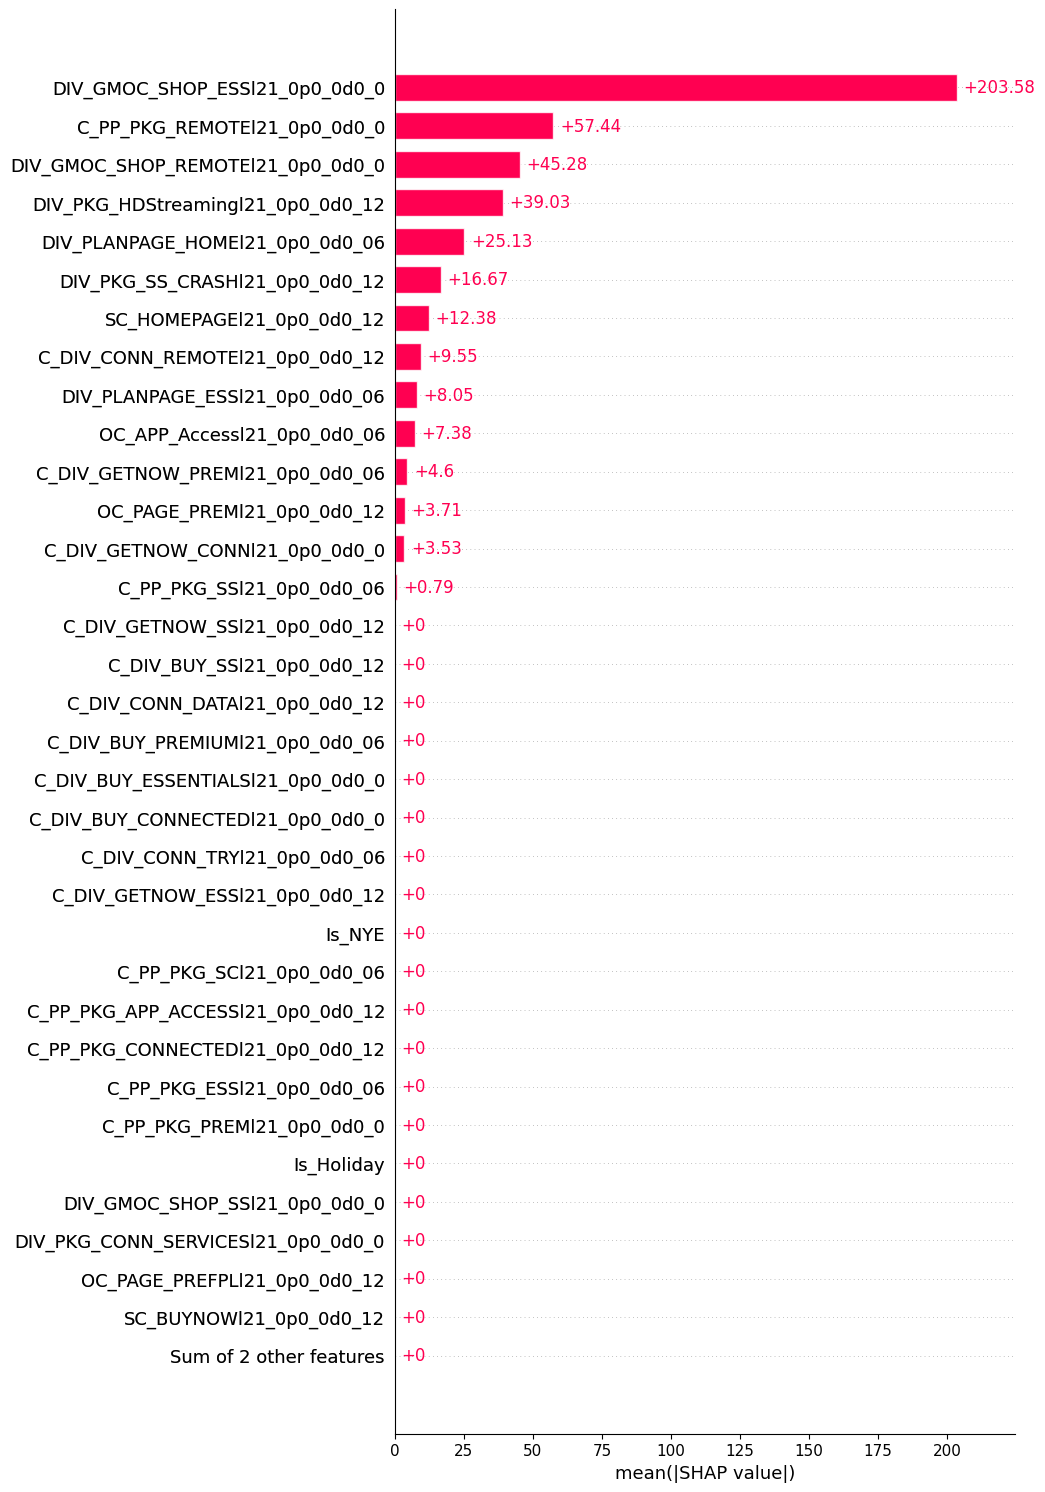

In [57]:
## shap values
shap.plots.bar(shap_values,max_display = len(df[df.columns[df.columns != KPI_COL]].columns))

In [58]:
vals= np.abs(shap_values.values).mean(axis = 0)

feature_importance = pd.DataFrame(list(zip(df[df.columns[df.columns != KPI_COL]].columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance

,col_name,feature_importance_vals
19,DIV_GMOC_SHOP_REMOTEl21_0p0_0d0_0,203.583211
16,C_PP_PKG_SCl21_0p0_0d0_06,57.444962
20,DIV_GMOC_SHOP_SSl21_0p0_0d0_0,45.280053
23,DIV_PKG_SS_CRASHl21_0p0_0d0_12,39.030959
26,OC_APP_Accessl21_0p0_0d0_06,25.130066
24,DIV_PLANPAGE_ESSl21_0p0_0d0_06,16.673529
31,SC_SHOPNOWl21_0p0_0d0_12,12.384842
6,C_DIV_CONN_TRYl21_0p0_0d0_06,9.554977
25,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,8.046048
27,OC_PAGE_PREFPLl21_0p0_0d0_12,7.378257


In [59]:
# rescale the shap values to result in a scale rleative to total r-squared

sum_feature_imp = feature_importance.feature_importance_vals.sum()
scale_factor = reg.score(X,y)

feature_importance['attribution'] = feature_importance.feature_importance_vals / (sum_feature_imp / scale_factor)
feature_importance

,col_name,feature_importance_vals,attribution
19,DIV_GMOC_SHOP_REMOTEl21_0p0_0d0_0,203.583211,0.436911
16,C_PP_PKG_SCl21_0p0_0d0_06,57.444962,0.123283
20,DIV_GMOC_SHOP_SSl21_0p0_0d0_0,45.280053,0.097176
23,DIV_PKG_SS_CRASHl21_0p0_0d0_12,39.030959,0.083765
26,OC_APP_Accessl21_0p0_0d0_06,25.130066,0.053932
24,DIV_PLANPAGE_ESSl21_0p0_0d0_06,16.673529,0.035783
31,SC_SHOPNOWl21_0p0_0d0_12,12.384842,0.026579
6,C_DIV_CONN_TRYl21_0p0_0d0_06,9.554977,0.020506
25,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,8.046048,0.017268
27,OC_PAGE_PREFPLl21_0p0_0d0_12,7.378257,0.015835


In [60]:
round(feature_importance.attribution.sum(),2)

0.94

## 4) Validate Linear Regression Model Assumptions

### 4.1) Generate model residuals

In [61]:
residuals = Y_prediction - y

#Y_prediction
#y

###4.2) Linearity

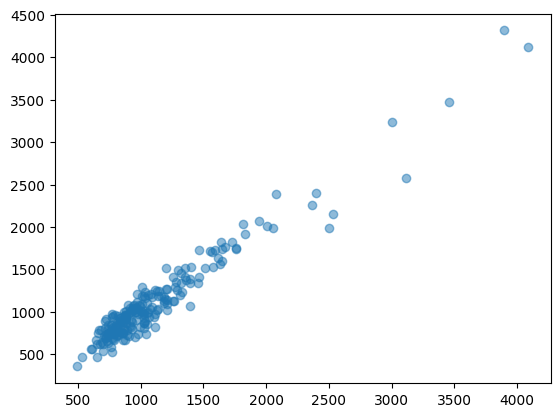

In [62]:
'''
Visually inspect linearity between target variable (y1) and predictions
'''
plt.plot(Y_prediction,y,'o',alpha=0.5)
plt.show()

### 4.3) Normality of Errors

In [63]:
'''
Visually inspect the residuals to confirm normality
'''

'\nVisually inspect the residuals to confirm normality\n'

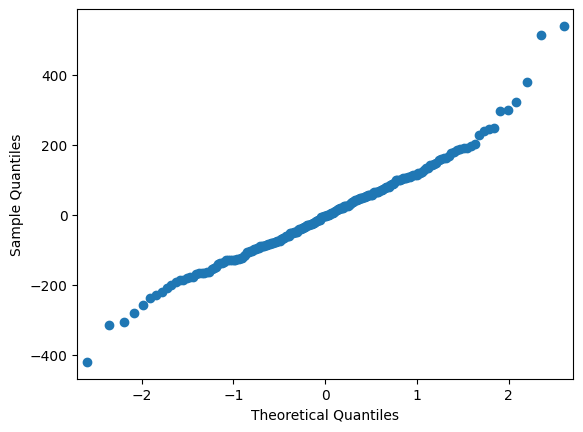

In [64]:
fig = sm.qqplot(residuals)

<ipython-input-65-24786c19d6f5>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, label = '', shade = True)


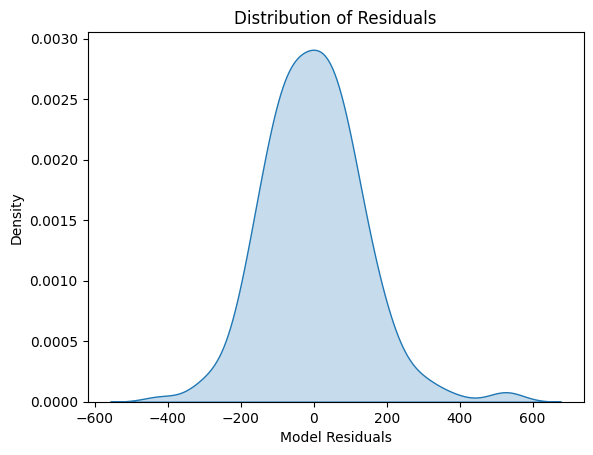

In [65]:
sns.kdeplot(residuals, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

###4.4) Homoscedasticity


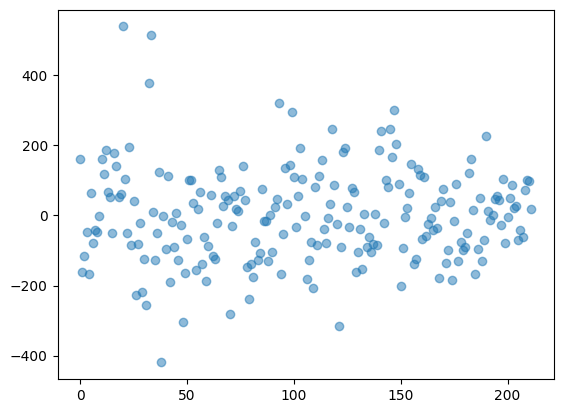

In [66]:
'''
Visually inspect residuals to confirm constant variance
'''
plt.plot(residuals,'o',alpha=0.5)
plt.show()

###4.5) Residual Autocorrelation Check

In [67]:
'''
The Durbin Watson test is a statistical test for detecting autocorrelation of the
model residuals
'''

dw = durbin_watson(residuals)
print('Durbin-Watson',dw)

Durbin-Watson 1.494033130677839


In [68]:
if dw < 1.5:
        print('Positive autocorrelation', '\n')
elif dw > 2.5:
        print('Negative autocorrelation', '\n')
else:
        print('Little to no autocorrelation', '\n')


Positive autocorrelation 



In [69]:
#df.head()

In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'X' is your predictors DataFrame

# Assuming 'df' is your DataFrame with all the predictor variables
#X = df.drop(columns = [KPI_COL, date_col], axis=1)  # Assuming 'y1' is your target variable
X = df.drop(columns = [KPI_COL], axis=1)  # Assuming 'y1' is your target variable

# Add a constant to the model (if it's not already included)
X = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                               Feature       VIF
0                                const  1.146926
1     C_DIV_BUY_CONNECTEDl21_0p0_0d0_0  6.269785
2    C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0  3.310056
3      C_DIV_BUY_PREMIUMl21_0p0_0d0_06  6.275167
4           C_DIV_BUY_SSl21_0p0_0d0_12  3.555037
5        C_DIV_CONN_DATAl21_0p0_0d0_12  1.840926
6      C_DIV_CONN_REMOTEl21_0p0_0d0_12  2.563439
7         C_DIV_CONN_TRYl21_0p0_0d0_06  1.442419
8       C_DIV_GETNOW_CONNl21_0p0_0d0_0  3.658483
9       C_DIV_GETNOW_ESSl21_0p0_0d0_12  1.593686
10     C_DIV_GETNOW_PREMl21_0p0_0d0_06  3.942930
11       C_DIV_GETNOW_SSl21_0p0_0d0_12  4.691398
12   C_PP_PKG_APP_ACCESSl21_0p0_0d0_12  1.930919
13    C_PP_PKG_CONNECTEDl21_0p0_0d0_12  5.619746
14          C_PP_PKG_ESSl21_0p0_0d0_06  4.223633
15          C_PP_PKG_PREMl21_0p0_0d0_0  4.751510
16        C_PP_PKG_REMOTEl21_0p0_0d0_0  9.502010
17           C_PP_PKG_SCl21_0p0_0d0_06  1.481955
18           C_PP_PKG_SSl21_0p0_0d0_06  2.816611
19      DIV_GMOC_SHO

## 5) Export Final Results

In [71]:
final_results_df = feature_importance[['col_name','attribution']]
final_results_df.to_csv('rba_final_output.csv', encoding = 'utf-8-sig')
files.download('rba_final_output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>